![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('datasets/test.txt').read())
val_file = unidecode.unidecode(open('datasets/validation.txt').read())
val_len = len(val_file)
file_len = len(file)
print('file_len =', file_len)

file_len = 4373595


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def random_val_chunk():
    start_index = random.randint(0, val_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return val_file[start_index:end_index]

print(random_chunk())

 acted, there could be no danger of it; and as long as
all mention of Bath scenes were avoided, she thought she could behave
to him very civilly. In such considerations time passed away, and it was
cer


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [4]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():
    while True:
        chunk = random_chunk()
        inp = char_tensor(chunk[:-1])
        target = char_tensor(chunk[1:])
        if len(inp) != 0 and len(target) !=0:
            break
    return inp, target

def random_validation_set():
    while True:
        chunk = random_val_chunk()
        inp = char_tensor(chunk[:-1])
        target = char_tensor(chunk[1:])
        if len(inp) != 0 and len(target) !=0:
            break
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [8]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].flatten())

    loss.backward()
    decoder_optimizer.step()

    return loss.item()/ chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [9]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        



 22s (100 5%) 2.2314]
Wh'gre orachery selachas and penttin omad the, mers the the now noum secot bestifty peer aress ang it  

 40s (200 10%) 2.7844]
Whe spandey
and surl; and of and for mbeted of thee for her at colditthe rounksed
at wheary fart Ren w 

 0s (300 15%) 2.2559]
Wh the Frary murt be had
a war And,  nothing the her a thove chanother shis
re, and her common of inte 

 17s (400 20%) 1.8902]
Whe wighto bele gould not whansterst seuced faen every she counten; the hin kent be must of there the  

 35s (500 25%) 1.8215]
Wh there in imsels her and the my her shich commed an the the nerated for there of penevery to the giv 

 53s (600 30%) 2.4637]
Whathat in." Heing sowning have
that of this he sall cruch pelessing thimshalleme," sarly, had pose it 

 10s (700 35%) 2.0379]
Whed faving have eder.
To _iEd. Wectoldles at fathery by it have not haver souch of kne said
having a  

 27s (800 40%) 1.8810]
Whon I give to was as present, and necere, but was eack.
"I the been hee to be clea

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

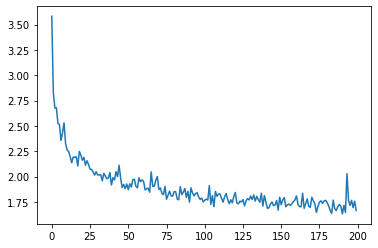

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)



# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [11]:
def validate(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].flatten())
        
    return loss.item()/ chunk_len

start = time.time()
val_all_losses = []
val_loss_avg = 0
totPerplexity = 0
ppAverage = 0
counter = 0
for epoch in range(1, n_epochs + 1):
    val_loss =  validate(*random_validation_set())       
    val_loss_avg += val_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')
        perplexity = math.exp(val_loss)
        print(perplexity)
        totPerplexity = totPerplexity + perplexity
        counter = counter + 1

    if epoch % plot_every == 0:
        val_all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
ppAverage = totPerplexity/ counter
print(ppAverage)


 7s (100 5%) 1.7303]
Whould not for a vervening he fatheran to could do her some is a forming, it it all the possead it am  

5.299183729580725
 13s (200 10%) 1.7303]
Wheor
mading thood it in the any to quite the persaily a wantle
on I am trike to uppersent with down y 

5.1646159807223855
 20s (300 15%) 1.7303]
Whelanced resemvoore
a resoldite the allatt of mote in the in Mrs. Marst like as I might its
was not a 

7.006435410294428
 27s (400 20%) 1.7303]
Whes would not poster on her ming to had peasition,
on. But I he had not love very in as meed lefte th 

8.522280940187079
 34s (500 25%) 1.7303]
Whose alway room an to sankifes or sping as
vile Mrs Chuss and mind in think, I can not belies. To not 

5.520426932792082
 41s (600 30%) 1.7303]
Wher he his had been you, I
are for pay pever it want a though more tem that the never repervaing in t 

4.772112130094987
 48s (700 35%) 1.7303]
When who were to his again the a replept love sith with prover the sam see is the
see her preseve, als

In [12]:
val_file = unidecode.unidecode(open('dataset/validation2.txt').read())
val_len = len(val_file)
n_epochs = 108
start = time.time()
val_all_losses = []
val_loss_avg = 0
totPerplexity = 0
ppAverage = 0
counter = 0
for epoch in range(1, n_epochs + 1):
    val_loss =  validate(*random_validation_set())       
    val_loss_avg += val_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')
        perplexity = math.exp(val_loss)
        print(perplexity)
        totPerplexity = totPerplexity + perplexity
        counter = counter + 1

    if epoch % plot_every == 0:
        val_all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
ppAverage = totPerplexity/ counter
print(ppAverage)


 6s (100 92%) 1.7303]
Whatl very be upprevent. An it
pleofbles plep propers been the was of he me shald the Edmund wave of t 

7.403221795293685
7.403221795293685


In [13]:
print(evaluate('Cake', 200, temperature=0.8))

Cake id very, for coather when
pointer not do bowfore poosers, and hem indentinought that it in is would a very exprove on the cannot it
Cown him in his regreal, as she woord good to here
thing it it grav


Lower temperatures are less varied, choosing only the more probable outputs:

In [14]:
print(evaluate('Th', 200, temperature=0.2))

Ther for a great in the some it it with in the grouse it in the said the never at the present the lance in the said the some in the some it a do not of the said the some it in the said a do not love a g


Higher temperatures more varied, choosing less probable outputs:

In [15]:
print(evaluate('Th', 200, temperature=1.4))

Thm grank from his
fathide, my esmin! shoust coracqually," is, I at I shade it."

"not had himsed! He garriak; a with mey, a t; shoubke and said_ formore,
pecclectlu, he wournayant you! Hen belily
othel


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)